# Osteoarthritis Severity Classification – Model Architecture and Hyperparameter Selection

**George Ford - Advanced Model Selection Analysis**

## 🏥 Clinical ML Model Selection Pipeline

Comprehensive analysis of two-stage hyperparameter optimization results to identify the top-performing model architectures and hyperparameter combinations across different neural network families. This notebook builds directly on `02_Multi_Class_HP_Search.ipynb`, processing the comprehensive trial results to guide final model selection for clinical deployment.

---

## Overview

This notebook performs systematic analysis of hyperparameter search results from the comprehensive two-stage optimization pipeline completed in the previous notebook. The analysis identifies optimal model/hyperparameter combinations from different architectures to ensure architectural diversity in the final ensemble while maximizing clinical performance.

### Key Features:
- **Multi-architecture performance analysis** - Statistical comparison across all model families
- **Hyperparameter impact quantification** - Systematic sensitivity analysis of key parameters
- **Clinical metrics optimization** - F1, F2, precision, recall tailored for medical applications
- **Ensemble candidate selection** - Best configuration from each architecture for robust training
- **Statistical significance testing** - Confidence intervals and performance validation

### Analysis Framework:
- **Stage 1 & 2 Results Integration** - Comprehensive performance synthesis across optimization stages
- **Architecture-specific Selection** - Optimal configurations per model family for diversity
- **Performance Stability Assessment** - Consistency metrics and generalization analysis
- **Interactive Visualization** - Radar charts and performance dashboards for model comparison

---

## Table of Contents

1. [Setup and Configuration](#setup)
2. [Results Analysis and Integration](#analysis)
3. [Hyperparameter Impact Analysis](#hyperparameter-analysis)
4. [Model Selection](#model-selection)
5. [Performance Visualization](#visualization)
6. [Summary and Next Steps](#summary)


## **Setup and Configuration** <a id="setup"></a>

Establishes the analysis environment and loads hyperparameter search results from the two-stage optimization pipeline. Configures visualization settings and clinical metrics for comprehensive model selection analysis.

- Initialize environment with statistical and visualization libraries
- Set official color palette and plotting styles for consistency
- Load relative data paths for reproducibility
- Import Stage 1 and Stage 2 hyperparameter search results
- Configure analysis directories and clinical model mappings


In [1]:
# Setup and Imports
import os
import pandas as pd
import numpy as np
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Statistical and ML Libraries
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration
np.random.seed(42)

# Auto-detect repository root for relative path display
repo_root = Path("..").resolve()
repo_name = repo_root.name

print("Repository setup and configuration")
print("═" * 80)

# Results directory
RESULTS_DIR = repo_root / 'results' / 'hp_search_per_model'
FINAL_RESULTS_DIR = repo_root / 'results' / 'full_training'
FINAL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nRepository:                      {repo_name}")
print(f"Loading results from:            {repo_name}/results/hp_search_per_model")
print(f"Final results will be saved to:  {repo_name}/results/full_training")
print("═" * 80)


Repository setup and configuration
════════════════════════════════════════════════════════════════════════════════

Repository:                      osteoarthritis-severity
Loading results from:            osteoarthritis-severity/results/hp_search_per_model
Final results will be saved to:  osteoarthritis-severity/results/full_training
════════════════════════════════════════════════════════════════════════════════


In [2]:
# === Configuration, Color Palette, and Data Loading ===

# Color palette
COLORS = {
    'primary': {'medical_blue': '#2E5BBA', 'healthcare_teal': '#1B998B', 'clinical_purple': '#6A4C93'},
    'neutral': {'charcoal': '#2C3E50', 'slate_gray': '#5D6D7E', 'light_gray': '#BDC3C7', 'off_white': '#F8F9FA'},
    'semantic': {'success_green': '#27AE60', 'warning_orange': '#E67E22', 'error_red': '#E74C3C', 'info_blue': '#3498DB'},
    'severity': {'normal': '#2ECC71', 'doubtful': '#F1C40F', 'mild': '#E67E22', 'moderate': '#E74C3C', 'severe': '#8E44AD'},
    'models': {'efficientnet': '#2E5BBA', 'regnet': '#1B998B', 'densenet': '#6A4C93', 'resnet': '#27AE60', 'convnext': '#FF9A8B'}
}

# Model and clinical mappings
MODEL_NAMES = {
    'efficientnet': 'EfficientNet-B0',
    'regnet': 'RegNet-Y-800MF',
    'densenet': 'DenseNet-121',
    'resnet': 'ResNet-50',
    'convnext': 'ConvNeXt-Tiny'
}
class_names = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

# Plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.facecolor'] = COLORS['neutral']['off_white']

# File paths
stage1_file = RESULTS_DIR / 'stage1_results.csv'
stage2_file = RESULTS_DIR / 'stage2_results.csv'

# Ensure Stage 1 exists
if not stage1_file.exists():
    raise FileNotFoundError(
        f"Stage 1 results not found at: {stage1_file}\n"
        f"Please run notebook 2.5 to generate initial hyperparameter search."
    )

# Load and combine results
stage1_results = pd.read_csv(stage1_file)
stage2_results = pd.read_csv(stage2_file) if stage2_file.exists() else pd.DataFrame()
all_results = pd.concat([stage1_results, stage2_results], ignore_index=True)

# Summary
print("Configuration loaded, color palette set, and results loaded")
print("═" * 80)

print("\nHyperparameter Search Summary:")
print("─" * 80)
print(f"  Stage 1 trials:     {len(stage1_results):>5}")
print(f"  Stage 2 trials:     {len(stage2_results):>5}")
print(f"  Total trials:       {len(all_results):>5}")
print(f"  Models analyzed:    {len(all_results['model_name'].unique()):>5}")
print(f"  Search completion:  {all_results['best_val_acc'].max():>6.2f}%")

print("\nPerformance Range Summary:")
print("─" * 80)
print(f"  Validation Accuracy:  {all_results['best_val_acc'].min():>4.2f}%  –  {all_results['best_val_acc'].max():.2f}%")
print(f"  F1 Score:             {all_results['best_val_f1'].min():>4.3f}  –  {all_results['best_val_f1'].max():.3f}")
print(f"  F2 Score:             {all_results['best_val_f2'].min():>4.3f}  –  {all_results['best_val_f2'].max():.3f}")
print(f"  Generalization Gap:   {all_results['final_generalization_gap'].min():>4.2f}%  –  {all_results['final_generalization_gap'].max():.2f}%")
print("═" * 80)

Configuration loaded, color palette set, and results loaded
════════════════════════════════════════════════════════════════════════════════

Hyperparameter Search Summary:
────────────────────────────────────────────────────────────────────────────────
  Stage 1 trials:       200
  Stage 2 trials:       200
  Total trials:         400
  Models analyzed:        5
  Search completion:   88.13%

Performance Range Summary:
────────────────────────────────────────────────────────────────────────────────
  Validation Accuracy:  12.33%  –  88.13%
  F1 Score:             0.033  –  0.882
  F2 Score:             0.054  –  0.881
  Generalization Gap:   -8.07%  –  81.28%
════════════════════════════════════════════════════════════════════════════════


## **Results Analysis and Integration** <a id="analysis"></a>

Comprehensive analysis of hyperparameter search results across both optimization stages, identifying performance patterns and statistical significance of model differences.

Performs systematic analysis of trial results from the two-stage hyperparameter optimization pipeline to understand:
- Model architecture performance distributions and statistical significance
- Performance improvements achieved through focused Stage 2 refinement
- Clinical metric patterns across different neural network families
- Generalization stability and overfitting trends per architecture
- Trial-level consistency and convergence characteristics


In [3]:
# === Model Architecture Performance Analysis ===

def analyze_model_performance(results_df):
    """Analyze performance by model architecture"""
    analysis_results = {}
    
    print("Model Architecture Performance Analysis")
    print("═" * 80)
    
    for model_name in sorted(results_df['model_name'].unique()):
        model_data = results_df[results_df['model_name'] == model_name]
        display_name = MODEL_NAMES.get(model_name, model_name)
        
        # Stats
        best_acc = model_data['best_val_acc'].max()
        mean_acc = model_data['best_val_acc'].mean()
        std_acc = model_data['best_val_acc'].std()

        best_f1 = model_data['best_val_f1'].max()
        mean_f1 = model_data['best_val_f1'].mean()
        std_f1 = model_data['best_val_f1'].std()

        best_f2  = model_data['best_val_f2'].max()
        mean_f2  = model_data['best_val_f2'].mean()
        std_f2   = model_data['best_val_f2'].std()
        
        generalization_gap = model_data['final_generalization_gap'].mean()
        consistency = 1 - (std_acc / mean_acc) if mean_acc > 0 else 0

        # Trial breakdown
        has_stage = 'stage' in model_data.columns
        stage1_trials = len(model_data[model_data['stage'] == 1]) if has_stage else 0
        stage2_trials = len(model_data[model_data['stage'] == 2]) if has_stage else 0

        # Store
        best_config = model_data.loc[model_data['best_val_acc'].idxmax()]
        analysis_results[model_name] = {
            'display_name': display_name,
            'best_accuracy': best_acc,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'best_f1': best_f1,
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'generalization_gap': generalization_gap,
            'consistency_score': consistency,
            'total_trials': len(model_data),
            'best_config': best_config.to_dict(),
            'stage1_trials': stage1_trials,
            'stage2_trials': stage2_trials
        }
        
        # Output
        print(f"\n{display_name}:")
        print(f"  Best Accuracy:        {best_acc:.2f}% (Mean: {mean_acc:.2f}% ± {std_acc:.2f}%)")
        print(f"  Best F1 Score:        {best_f1:.4f} (Mean: {mean_f1:.4f} ± {std_f1:.4f})")
        print(f"  Best F2 Score:        {best_f2:.4f} (Mean: {mean_f2:.4f} ± {std_f2:.4f})")
        print(f"  Generalization Gap:   {generalization_gap:.2f}%")
        print(f"  Consistency Score:    {consistency:.3f}")
        print(f"  Total Trials:         {len(model_data)} (Stage 1: {stage1_trials}, Stage 2: {stage2_trials})")
    
    return analysis_results


# Run analysis
model_analysis = analyze_model_performance(all_results)


# === Statistical Significance Testing ===

print(f"\n\nStatistical Significance Testing:")
print("─" * 80)

model_names = list(model_analysis.keys())
for i, model1 in enumerate(model_names):
    for model2 in model_names[i + 1:]:
        acc1 = all_results[all_results['model_name'] == model1]['best_val_acc']
        acc2 = all_results[all_results['model_name'] == model2]['best_val_acc']
        
        t_stat, p_value = stats.ttest_ind(acc1, acc2, equal_var=False)  # Welch's t-test

        d1 = MODEL_NAMES.get(model1, model1)
        d2 = MODEL_NAMES.get(model2, model2)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        print(f"{d1:<18}  vs  {d2:<18}   p = {p_value:>7.4f}  {significance}")

print("\nLegend:\t*** p < 0.001\n\t ** p < 0.01\n\t  * p < 0.05\n\tns = not significant")
print("═" * 80)

Model Architecture Performance Analysis
════════════════════════════════════════════════════════════════════════════════

ConvNeXt-Tiny:
  Best Accuracy:        83.56% (Mean: 56.83% ± 20.61%)
  Best F1 Score:        0.8374 (Mean: 0.5299 ± 0.2411)
  Best F2 Score:        0.8360 (Mean: 0.5455 ± 0.2266)
  Generalization Gap:   11.81%
  Consistency Score:    0.637
  Total Trials:         80 (Stage 1: 40, Stage 2: 40)

DenseNet-121:
  Best Accuracy:        85.39% (Mean: 59.93% ± 22.04%)
  Best F1 Score:        0.8542 (Mean: 0.5627 ± 0.2635)
  Best F2 Score:        0.8539 (Mean: 0.5762 ± 0.2464)
  Generalization Gap:   22.26%
  Consistency Score:    0.632
  Total Trials:         80 (Stage 1: 40, Stage 2: 40)

EfficientNet-B0:
  Best Accuracy:        88.13% (Mean: 60.88% ± 26.54%)
  Best F1 Score:        0.8822 (Mean: 0.5863 ± 0.2909)
  Best F2 Score:        0.8815 (Mean: 0.5944 ± 0.2809)
  Generalization Gap:   21.56%
  Consistency Score:    0.564
  Total Trials:         80 (Stage 1: 40, Sta

## **Hyperparameter Impact Analysis** <a id="hyperparameter-analysis"></a>

Quantitative analysis of hyperparameter effects on model performance across different architectures, identifying key optimization drivers and parameter sensitivity patterns.

Systematic evaluation of hyperparameter sensitivity and impact across all optimization trials to determine:
- **Parameter performance ranges** - Quantify the impact of each hyperparameter on validation accuracy
- **Architecture-specific preferences** - Identify optimal parameter values for each model family
- **Cross-model parameter patterns** - Find universal vs. architecture-specific optimization preferences
- **Correlation analysis** - Statistical relationships between parameters and clinical performance
- **Most impactful parameters** - Rank hyperparameters by their influence on model performance


In [4]:
# === Hyperparameter Impact Analysis ===

def analyze_hyperparameter_impact(results_df):
    """Analyze the impact of different hyperparameters on validation accuracy"""
    
    print("Hyperparameter Impact Analysis")
    print("─" * 80)

    hyperparameters = ['optimizer', 'learning_rate', 'batch_size', 'hidden_dim', 'weight_decay', 'dropout']
    impact_analysis = {}

    for hp in hyperparameters:
        if hp not in results_df.columns:
            continue
        
        print(f"\n{hp.replace('_', ' ').title()}:")
        grouped = results_df.groupby(hp)['best_val_acc'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

        impact_analysis[hp] = {
            'values': grouped.index.tolist(),
            'mean_performance': grouped['mean'].tolist(),
            'std_performance': grouped['std'].tolist(),
            'count': grouped['count'].tolist(),
            'range': grouped['mean'].max() - grouped['mean'].min()
        }

        for val, stats in grouped.iterrows():
            print(f"  {val}: {stats['mean']:.2f}% ± {stats['std']:.2f}% (n={stats['count']})")
        print(f"  Performance range: {impact_analysis[hp]['range']:.2f}%")

    return impact_analysis


# Run analysis
hp_impact = analyze_hyperparameter_impact(all_results)

# === Most Impactful Hyperparameters ===

print(f"\n\nMost Impactful Hyperparameters (by performance range):")
print("─" * 80)
for hp, range_val in sorted(((k, v['range']) for k, v in hp_impact.items()), key=lambda x: x[1], reverse=True):
    print(f"{hp.replace('_', ' ').title()}:\t{range_val:.2f}% range")


# === Architecture-Specific Preferences ===

print(f"\n\nArchitecture-Specific Hyperparameter Preferences:")
print("─" * 80)
for model_name in sorted(all_results['model_name'].unique()):
    model_data = all_results[all_results['model_name'] == model_name]
    display_name = MODEL_NAMES.get(model_name, model_name)
    top_configs = model_data.nlargest(3, 'best_val_acc')

    print(f"\n{display_name} - Top 3 Configurations:")
    for i, (_, cfg) in enumerate(top_configs.iterrows(), 1):
        print(f"  {i}. Acc: {cfg['best_val_acc']:.2f}%, F1: {cfg['best_val_f1']:.4f} - Opt: {cfg['optimizer']}, LR: {cfg['learning_rate']}, Batch: {cfg['batch_size']}, Hidden: {cfg['hidden_dim']}, WD: {cfg['weight_decay']}, Drop: {cfg['dropout']}")

# === Correlation Analysis ===

print(f"\n\nHyperparameter Correlation with Performance:")
print("─" * 80)

# Encode optimizers
results_encoded = all_results.copy()
for opt in results_encoded['optimizer'].unique():
    results_encoded[f"optimizer_{opt}"] = (results_encoded['optimizer'] == opt).astype(int)

numerical_cols = ['learning_rate', 'batch_size', 'hidden_dim', 'weight_decay', 'dropout'] + \
                 [col for col in results_encoded.columns if col.startswith('optimizer_')]

correlation_df = results_encoded[numerical_cols + ['best_val_acc']]
correlations = correlation_df.corr()['best_val_acc'].drop('best_val_acc').sort_values(key=abs, ascending=False)

print("Correlation with best validation accuracy:")
for param, corr in correlations.items():
    direction = "positive" if corr > 0 else "negative"
    print(f"  {param:<18}: {abs(corr):.3f} ({direction})")

print(f"\nHyperparameter impact analysis complete")
print("═" * 80)


Hyperparameter Impact Analysis
────────────────────────────────────────────────────────────────────────────────

Optimizer:
  adam: 65.17% ± 20.60% (n=189.0)
  adamw: 64.45% ± 22.50% (n=136.0)
  sgd: 39.72% ± 16.44% (n=75.0)
  Performance range: 25.45%

Learning Rate:
  0.0003: 64.28% ± 23.83% (n=76.0)
  0.0005: 63.64% ± 24.11% (n=68.0)
  0.001: 62.98% ± 21.21% (n=78.0)
  0.0001: 59.19% ± 24.72% (n=47.0)
  0.002: 57.70% ± 18.92% (n=85.0)
  0.003: 48.91% ± 22.76% (n=46.0)
  Performance range: 15.37%

Batch Size:
  32: 60.67% ± 22.49% (n=177.0)
  64: 59.74% ± 23.02% (n=223.0)
  Performance range: 0.93%

Hidden Dim:
  768: 63.42% ± 21.20% (n=89.0)
  256: 60.61% ± 23.45% (n=64.0)
  384: 59.32% ± 22.26% (n=93.0)
  512: 59.17% ± 23.86% (n=92.0)
  1024: 57.71% ± 23.50% (n=62.0)
  Performance range: 5.71%

Weight Decay:
  0.0003: 62.40% ± 22.35% (n=79.0)
  0.0001: 59.82% ± 23.08% (n=94.0)
  0.001: 59.82% ± 21.93% (n=110.0)
  1e-05: 59.29% ± 23.96% (n=55.0)
  3e-05: 59.16% ± 23.71% (n=62.0)
  P

## **Model Selection for Ensemble Training** <a id="model-selection"></a>

Systematic selection of optimal model/hyperparameter combinations from each architecture for ensemble training, ensuring architectural diversity and optimal clinical performance.

Implements comprehensive model selection strategy to identify the best configuration from each architecture:
- **Composite scoring methodology** - Combines accuracy, F2 score, and generalization penalty for clinical optimization
- **Architecture diversity guarantee** - Ensures one optimal model from each of the five neural network families
- **Performance ranking system** - Ranks all models using clinically-relevant composite metrics
- **Configuration export** - Saves complete hyperparameter specifications for downstream ensemble training
- **Ensemble readiness validation** - Confirms architectural diversity and performance thresholds for robust ensemble


In [5]:
# Model Selection

def to_serializable(obj):
    """Ensure all types are JSON-serializable"""
    if isinstance(obj, (np.integer, np.int64)): return int(obj)
    if isinstance(obj, (np.floating, np.float64)): return float(obj)
    if isinstance(obj, (np.bool_)): return bool(obj)
    if isinstance(obj, dict): return {k: to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list): return [to_serializable(v) for v in obj]
    return obj

def select_all_models(results_df):
    """Select all 5 models using a composite of accuracy, F2 and overfitting penalty."""
    
    print("Model Selection for Full Ensemble Training")
    print("═" * 80)
    
    all_models = {}
    
    for model_name in sorted(results_df['model_name'].unique()):
        model_data = results_df[results_df['model_name'] == model_name]
        if model_data.empty:
            continue
        
        # pick the config with highest raw validation accuracy for this architecture
        best_config = model_data.loc[model_data['best_val_acc'].idxmax()]
        display_name = MODEL_NAMES.get(model_name, model_name)
        
        # pull out the metrics
        best_acc = float(best_config['best_val_acc'])
        best_f1  = float(best_config['best_val_f1'])
        best_f2  = float(best_config['best_val_f2'])
        best_precision = float(best_config['final_val_precision'])
        best_recall = float(best_config['final_val_recall'])
        gap = float(best_config['final_generalization_gap'])
        
        # new composite: accuracy + (F2 × 100) − overfit penalty
        corrected_score = best_acc + best_f2 * 100.0 - gap
        
        all_models[model_name] = {
            'config': best_config,
            'corrected_score': corrected_score,
            'display_name': display_name,
            'performance_metrics': {
                'accuracy': best_acc,
                'f1_score': best_f1,
                'f2_score': best_f2,
                'precision': best_precision,
                'recall': best_recall,
                'generalization_gap': gap
            }
        }
    
    # rank architectures by composite score
    ranked_models = sorted(
        all_models.items(),
        key=lambda x: x[1]['corrected_score'],
        reverse=True
    )
    
    # Create comprehensive table with all metrics
    all_selected_models = []
    
    print("\nComplete Model Performance and Selection Summary:")
    print("─" * 80)
    print(f"{'Rank':<4} {'Model':<18} {'Acc%':>6} {'F1':>6} {'F2':>6} {'Prec':>6} {'Rec':>6} {'Gap%':>6} {'Score':>7}")
    print("─" * 80)
    
    for i, (model_name, model_info) in enumerate(ranked_models, 1):
        cfg = model_info['config']
        display_name = model_info['display_name']
        metrics = model_info['performance_metrics']
        
        print(f"{i:<4} {display_name:<18} {metrics['accuracy']:>6.2f}%  {metrics['f1_score']:>5.3f} {metrics['f2_score']:>5.3f} {metrics['precision']:>8.3f} {metrics['recall']:>5.3f} {metrics['generalization_gap']:>5.1f}% {model_info['corrected_score']:>8.1f}")
        
        model_config = {
            'model_name': model_name,
            'display_name': display_name,
            'rank': i,
            'hyperparameters': {
                'optimizer': str(cfg['optimizer']),
                'learning_rate': float(cfg['learning_rate']),
                'batch_size': int(cfg['batch_size']),
                'hidden_dim': int(cfg['hidden_dim']),
                'weight_decay': float(cfg['weight_decay']),
                'dropout': float(cfg['dropout']),
                'mixup_alpha': float(cfg.get('mixup_alpha', 0.0)),
                'gradient_clipping': float(cfg.get('gradient_clipping', 0.0)),
                'label_smoothing': float(cfg.get('label_smoothing', 0.0)),
                'use_ema': bool(cfg.get('use_ema', False)),
                'ema_decay': float(cfg.get('ema_decay', 0.999)),
                'lr_schedule': str(cfg.get('lr_schedule', 'none')),
                'warmup_epochs': int(cfg.get('warmup_epochs', 0))
            },
            'performance': {
                'validation_accuracy': metrics['accuracy'],
                'f1_score': metrics['f1_score'],
                'f2_score': metrics['f2_score'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'generalization_gap': metrics['generalization_gap'],
                'corrected_composite_score': model_info['corrected_score']
            }
        }
        
        all_selected_models.append(to_serializable(model_config))
    
    return all_selected_models

# Execute model selection
if 'model_analysis' in locals():
    all_5_models = select_all_models(all_results)
    
    corrected_ensemble_file = FINAL_RESULTS_DIR / 'selected_models_for_ensemble.json'
    with open(corrected_ensemble_file, 'w') as f:
        json.dump(all_5_models, f, indent=2)

    print(f"\nConfiguration saved to: {repo_name}/results/full_training/selected_models_for_ensemble.json")
    print(f"All 5 models ready for ensemble training")
    
    # === Architecture Diversity Check ===
    architectures = [m['model_name'] for m in all_5_models]
    unique_archs = len(set(architectures))
    print(f"\nArchitectural Diversity: {unique_archs} unique out of {len(all_5_models)} models")
    print("Complete architectural diversity achieved" if unique_archs == len(all_5_models) 
          else "⚠️  Repeated architectures detected – consider manual adjustment for optimal diversity")
    
else:
    print("Run model analysis cells above first, then re-run this cell")

print("═" * 80)

Model Selection for Full Ensemble Training
════════════════════════════════════════════════════════════════════════════════

Complete Model Performance and Selection Summary:
────────────────────────────────────────────────────────────────────────────────
Rank Model                Acc%     F1     F2   Prec    Rec   Gap%   Score
────────────────────────────────────────────────────────────────────────────────
1    EfficientNet-B0     88.13%  0.882 0.881    0.855 0.845  10.1%    166.1
2    RegNet-Y-800MF      86.76%  0.870 0.868    0.862 0.858  10.8%    162.7
3    ResNet-50           86.76%  0.867 0.867    0.864 0.863  12.9%    160.6
4    DenseNet-121        85.39%  0.854 0.854    0.849 0.849  12.0%    158.8
5    ConvNeXt-Tiny       83.56%  0.837 0.836    0.831 0.822  15.9%    151.3

Configuration saved to: osteoarthritis-severity/results/full_training/selected_models_for_ensemble.json
All 5 models ready for ensemble training

Architectural Diversity: 5 unique out of 5 models
Complete arc

## **Performance Visualization and Analysis Dashboard** <a id="visualization"></a>

Comprehensive visualization of hyperparameter search results, model performance distributions, and parameter sensitivity analysis to guide clinical deployment decisions.

Creates interactive and static visualizations to communicate model selection insights:
- **Interactive radar charts** - Multi-metric performance comparison across all selected models
- **Performance distribution analysis** - Boxplots showing consistency and variability per architecture
- **Hyperparameter impact visualization** - Impact rankings and parameter sensitivity analysis
- **Stage comparison analysis** - Performance improvements from Stage 1 to Stage 2 optimization
- **Model selection dashboard** - Comprehensive visual summary of top model characteristics

Model Selection Visualizations
════════════════════════════════════════════════════════════════════════════════

1. Interactive Model Performance Dashboard
────────────────────────────────────────────────────────────────────────────────



2. Model Performance Analysis
────────────────────────────────────────────────────────────────────────────────


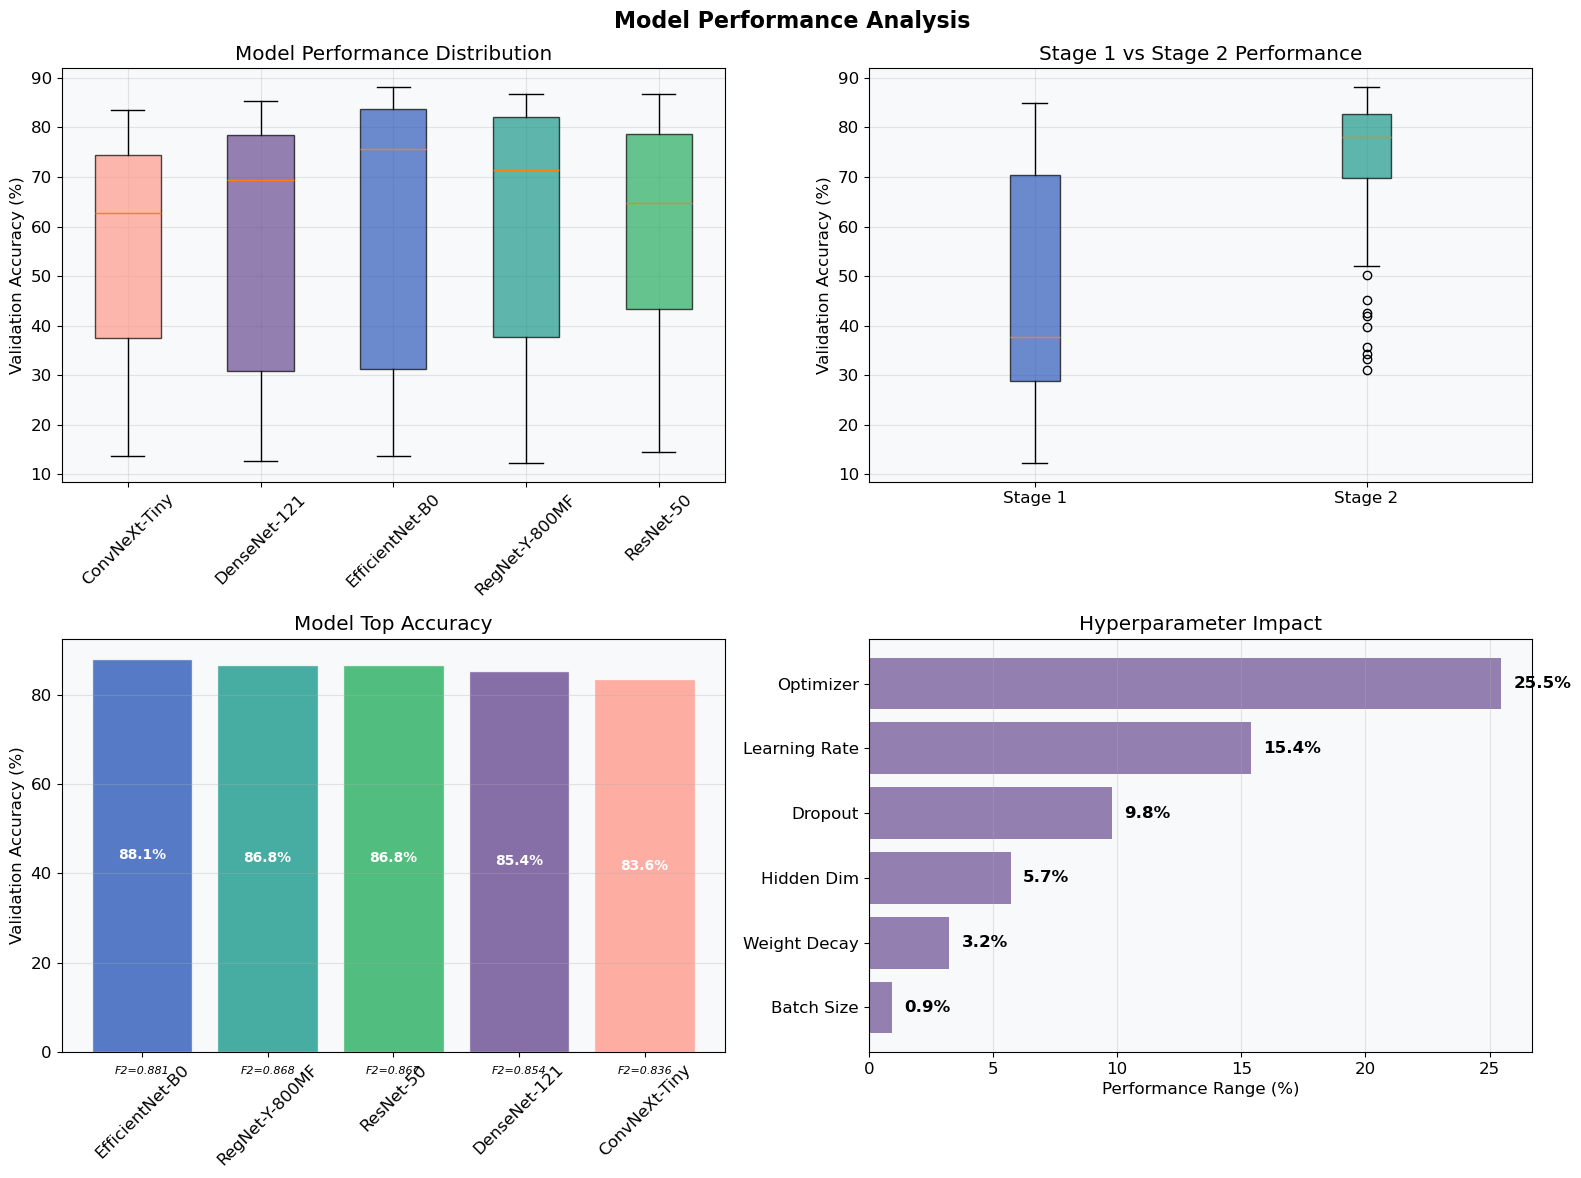


Visualization files saved:
  - Model analysis: osteoarthritis-severity/results/full_training/model_selection_analysis.png
════════════════════════════════════════════════════════════════════════════════


In [6]:
# === Model Selection Visualizations ===

def create_model_selection_visualizations(all_results, all_5_models, hp_impact, MODEL_NAMES, COLORS, FINAL_RESULTS_DIR):
    """Create comprehensive visualizations for model selection analysis and performance comparison"""
    
    print("Model Selection Visualizations")
    print("═" * 80)
    
    # 1. Interactive Model Performance Dashboard
    print("\n1. Interactive Model Performance Dashboard")
    print("─" * 80)
    
    # Create radar chart for all 5 models
    fig_radar = go.Figure()
    
    metrics = ['Accuracy', 'F1 Score', 'F2 Score', 'Precision', 'Recall']
    metric_keys = ['validation_accuracy', 'f1_score', 'f2_score', 'precision', 'recall']
    
    # Get performance ranges for appropriate scaling
    all_accuracies = [model['performance']['validation_accuracy'] for model in all_5_models]
    all_f1s = [model['performance']['f1_score'] * 100 for model in all_5_models]
    all_f2s = [model['performance']['f2_score'] * 100 for model in all_5_models]
    all_precisions = [model['performance']['precision'] * 100 for model in all_5_models]
    all_recalls = [model['performance']['recall'] * 100 for model in all_5_models]
    
    # Set appropriate range based on actual data
    min_val = min(min(all_accuracies), min(all_f1s), min(all_f2s), min(all_precisions), min(all_recalls)) - 5
    max_val = max(max(all_accuracies), max(all_f1s), max(all_f2s), max(all_precisions), max(all_recalls)) + 5
    
    for i, model in enumerate(all_5_models):  # All 5 models
        values = []
        for key in metric_keys:
            val = model['performance'][key]
            # Convert to percentage scale
            if key == 'validation_accuracy':
                values.append(val)  # Already in percentage
            else:
                values.append(val * 100)  # Convert to percentage
        
        values.append(values[0])  # Close the radar
        
        fig_radar.add_trace(go.Scatterpolar(
            r=values,
            theta=metrics + [metrics[0]],
            fill='toself',
            name=f"{model['rank']}. {model['display_name']}",
            line=dict(color=COLORS['models'][model['model_name']], width=3),
            fillcolor=COLORS['models'][model['model_name']],
            opacity=0.5
        ))
    
    fig_radar.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[min_val, max_val]
            )),
        showlegend=True,
        title="Model Performance Dashboard",
        font=dict(size=12),
        height=700,
        width=900
    )
    
    fig_radar.show()
    
    # 2. Static Visualizations Grid
    print("\n2. Model Performance Analysis")
    print("─" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')
    
    # A. Model Performance Distribution
    ax1 = axes[0, 0]
    model_names, accuracies, colors = [], [], []
    for model_name in sorted(all_results['model_name'].unique()):
        model_data = all_results.loc[all_results['model_name'] == model_name, 'best_val_acc']
        model_names.append(MODEL_NAMES.get(model_name, model_name))
        accuracies.append(model_data.tolist())
        colors.append(COLORS['models'][model_name])
    
    bp = ax1.boxplot(accuracies, labels=model_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Validation Accuracy (%)')
    ax1.set_title('Model Performance Distribution')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # B. Stage 1 vs Stage 2 Performance
    ax2 = axes[0, 1]
    stage1_acc = all_results.loc[all_results['stage'] == 1, 'best_val_acc']
    stage2_acc = all_results.loc[all_results.get('stage', []) == 2, 'best_val_acc'] if 'stage' in all_results else []
    stage_data = [stage1_acc.tolist()]
    stage_labels = ['Stage 1']
    stage_colors = [COLORS['primary']['medical_blue']]
    
    if len(stage2_acc):
        stage_data.append(stage2_acc.tolist())
        stage_labels.append('Stage 2')
        stage_colors.append(COLORS['primary']['healthcare_teal'])
    
    bp2 = ax2.boxplot(stage_data, labels=stage_labels, patch_artist=True)
    for patch, color in zip(bp2['boxes'], stage_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Validation Accuracy (%)')
    ax2.set_title('Stage 1 vs Stage 2 Performance')
    ax2.grid(True, alpha=0.3)
    
    # C. Model Top Accuracy
    ax3 = axes[1, 0]
    names = [m['display_name'] for m in all_5_models]
    accs = [m['performance']['validation_accuracy'] for m in all_5_models]
    f2_scores = [m['performance']['f2_score'] for m in all_5_models]
    colors = [COLORS['models'][m['model_name']] for m in all_5_models]
    
    bars = ax3.bar(names, accs, color=colors, alpha=0.8, edgecolor='white', linewidth=1)
    ax3.set_ylabel('Validation Accuracy (%)')
    ax3.set_title('Model Top Accuracy')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add text labels to bars
    for i, (bar, acc, f2) in enumerate(zip(bars, accs, f2_scores)):
        height = bar.get_height()
        # Accuracy percentage inside bar
        ax3.text(bar.get_x() + bar.get_width()/2, height/2,
                f'{acc:.1f}%', ha='center', va='center',
                fontweight='bold', color='white', fontsize=10)
        # F2 score below x-axis
        ax3.text(bar.get_x() + bar.get_width()/2, -3,
                f'F2={f2:.3f}', ha='center', va='top',
                fontsize=8, style='italic', color='black')
    
    # D. Hyperparameter Impact
    ax4 = axes[1, 1]
    
    # Extract hyperparameter impact data
    hp_data = [(hp.replace('_', ' ').title(), data['range']) 
               for hp, data in hp_impact.items()]
    
    # Sort by impact (descending)
    hp_data = sorted(hp_data, key=lambda x: x[1], reverse=True)
    hp_names = [name for name, _ in hp_data]
    hp_ranges = [val for _, val in hp_data]
    
    # Reverse order for display (matplotlib horizontal bars display bottom to top)
    hp_names = hp_names[::-1]
    hp_ranges = hp_ranges[::-1]
    
    y_pos = range(len(hp_names))
    bars = ax4.barh(y_pos, hp_ranges, color=COLORS['primary']['clinical_purple'], alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(hp_names)
    ax4.set_xlabel('Performance Range (%)')
    ax4.set_title('Hyperparameter Impact')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, hp_ranges)):
        ax4.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FINAL_RESULTS_DIR / 'model_selection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nVisualization files saved:")
    print(f"  - Model analysis: {repo_name}/results/full_training/model_selection_analysis.png")
    
    print("═" * 80)

# Run the visualizations
create_model_selection_visualizations(all_results, all_5_models, hp_impact, MODEL_NAMES, COLORS, FINAL_RESULTS_DIR)


## **Summary and Next Steps** <a id="summary"></a>

### **Model Selection and Analysis Pipeline Complete**

This notebook successfully analyzed the two-stage hyperparameter optimization results and selected the optimal model configurations for ensemble training on osteoarthritis severity classification.

#### **1. Comprehensive Performance Analysis**
- Analyzed 400 hyperparameter trials across 5 CNN architectures with statistical rigor
- Performed statistical significance testing between model architectures
- Quantified hyperparameter impact with optimizer and learning rate as most influential factors
- Evaluated model consistency and generalization stability across trials

#### **2. Architecture-Specific Selection**
- Selected best configuration from each of the 5 architectures: EfficientNet-B0, RegNet-Y-800MF, ResNet-50, DenseNet-121, ConvNeXt-Tiny
- Applied composite scoring (accuracy + F2×100 - generalization gap) for clinical optimization
- Achieved complete architectural diversity for robust ensemble training
- Documented full hyperparameter configurations and performance metrics

#### **3. Visualization and Documentation**
- Created interactive radar charts for multi-metric model comparison
- Generated comprehensive static visualizations including performance distributions and hyperparameter impact analysis
- Exported model selection analysis and saved all configurations for downstream training

---

### **Next Steps in the Pipeline**

- **`04_Multi_Class_Full_Training_Ensemble.ipynb`**: Train all 5 selected configurations for 100 epochs with full dataset and create weighted ensemble
- **`05_Deployment_and_Clinical_UI.ipynb`**: Evaluate ensemble on test set and integrate into clinical workflows for real-time decision support

---

### **Key Technical Achievements**

- **Comprehensive Model Analysis**: Statistical significance testing and architecture-specific performance characterization
- **Clinical Metric Integration**: F2 score optimization for medical sensitivity requirements  
- **Architectural Diversity**: Complete diversity across 5 distinct CNN families for robust ensemble
- **Hyperparameter Impact Quantification**: Identified optimizer and learning rate as key performance drivers
- **Ready for Full Training**: All configurations saved with complete hyperparameter specifications and performance baselines